# Entity Recognition with deep Learning

## Objective: 

using transfert learning to build a task specific language model. Fine tune this language model for Entity Recognition (ER).


# MAGICS: please run all
imports and setup.

You need to replace in their cell:
* work_p, the main directory
* data_p the name of the data tar archive inside the main directory.
* label_p, the name of the labelled file inside the main directory.
folder need to be setup this way:
* work_p
  * label_p (the labelled file)
  * data_p (the raw data file)


DAta can be downloaded from:

http://di2kg.inf.uniroma3.it/2020/#challenge-downloads

It is:
* Round 1 Dataset XMONITOR
* Round 1 Dataset YERMONITOR

the dataset YERMONITOR may have to be resave to csv file manually. 



In [ ]:
#ninja is used to be able to run some cpp code and do thing with cuda.
!pip install ninja

     |████████████████████████████████| 112kB 8.1MB/s 


In [ ]:
#fastai is  a deep learning library built on pytorch 
!pip install -U fastai

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.61)


In [ ]:
# https://github.com/fastai/fastai/issues/2563
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
from  pathlib import *
import pandas as pd
import tarfile
import numpy as np
import pickle

In [ ]:
from typing import *
from fastai.text import *

In [ ]:
from functools import reduce, partial

In [ ]:
#name of the labeled data from the challenge
label_p=Path("monitor_entity_resolution_labelled_data_v2_05_26_2020.csv")
#name of the dataset from the challenge in the tar archive. 
data_p=Path("2013_monitor_specs.tar.gz")

In [ ]:
# I am google colab and the data is in my drive.
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [ ]:
work_p="drive/My Drive/ER"
work = Path(work_p)
work.mkdir(exist_ok=True)

In [ ]:
label=pd.read_csv(work/label_p, delimiter=",")

# SETUP


## Importing the json data

In [ ]:
import json

In [ ]:
# load the jsons dataset. It load it as dictionnary into jdic.
#nota: it jdic is {sourcewebsite:[list of items dictionnaries]}
#nota: id is used to map index to website//number.

def load_jsons(path):
  jdic = {}
  curf = None #current folder name
  id = []
  folders = [] # to keep track of the names of the sub-folders. Not used currently. 
  pd_data = []
  with  tarfile.open(path,"r") as tar: 
    for member in tar.getmembers():
      if member.isfile():
        f = tar.extractfile(member.name)
        jdic[curf].append(json.load(f))
        id.append(member.name)
      elif member.isdir():
        print(member.name)
        curf=member.name
        if member.name != "2013_monitor_specs": jdic[member.name]=[]
        folders.append(member.name)
  return jdic, id

In [ ]:
#we load all the jsons as dictionnary in memory.
#as well as id, which lists the names (ebay//123 ...)
jdic, id = load_jsons(work/data_p)

2013_monitor_specs
2013_monitor_specs/ca.pcpartpicker.com
2013_monitor_specs/catalog.com
2013_monitor_specs/ce.yikus.com
2013_monitor_specs/www.best-deal-items.com
2013_monitor_specs/www.cleverboxes.com
2013_monitor_specs/www.ebay.com
2013_monitor_specs/www.getprice.com.au
2013_monitor_specs/www.hardware-planet.it
2013_monitor_specs/www.imldirect.it
2013_monitor_specs/www.itenergy.co.uk
2013_monitor_specs/www.jrlinton.co.uk
2013_monitor_specs/www.kingsfieldcomputers.co.uk
2013_monitor_specs/www.makingbuyingeasy.co.uk
2013_monitor_specs/www.mediashopuk.com
2013_monitor_specs/www.mrhightech.com
2013_monitor_specs/www.nexus-t.co.uk
2013_monitor_specs/www.odsi.co.uk
2013_monitor_specs/www.officedepot.com
2013_monitor_specs/www.ohc24.ch
2013_monitor_specs/www.pc-canada.com
2013_monitor_specs/www.pcconnection.com
2013_monitor_specs/www.planet-computer.it
2013_monitor_specs/www.shopmania.com
2013_monitor_specs/www.softwarecity.ca
2013_monitor_specs/www.vology.com
2013_monitor_specs/www.xpcpro

## cleaning the data per-source

Even if the above note proposes a way to do without cleaning, I propose to tidy a bit by:

* removing source specific words in the title attribute (since it is the columns sharded by all sources)
* remove attribute where the value does not changes.

In [ ]:
#returns a list of the words that appears too much in a source title
def bad_words(jdic, threshold=0.5):

  #return all ngrams that are present more in, more that threshold% title of a source.
  from sklearn.feature_extraction.text import CountVectorizer

  #we only do the cleaning in the title column
  titles_doc = [" ".join(d["<page title>"] for d in source ) for source in jdic.values()]
  sourcevectorizer = CountVectorizer(ngram_range=(1,5),)
  source_counts = sourcevectorizer.fit_transform(titles_doc) # get the matrix source / word count
  source_size = np.array([len(d) for d in jdic.values()])
  source_freq = source_counts / source_size[:,np.newaxis] #divide by size to get frequency
  bad_indices = (source_freq>threshold).any(axis=0) #get the indices of words that have a too high frequency 
  tock=np.array(sourcevectorizer.get_feature_names()) #get the words from the indices
  bad = tock[bad_indices.flat]
  return bad

In [ ]:
import re
def to_re(substrings):
  #return a compiled re to match the substrings in strings
  #array is sorted to match the longest substring first.
  return re.compile(rf"\b({'|'.join(sorted(substrings, key=len,reverse=True))})\b")

converting the jsons ditionnary to text.

We print the dictionnaries, replacing the keys by `FLD i` where `FLD` is a tocken denoting a new field, and `i` is the number of this field.

In [ ]:
#utility class to print a dictonnary in a reasonable way. 
#transforms are applied to each dic field after taking the string
#filters are applied to know if a key - filed pair is printed. 
#the processor class is inspired by the fastai library 
# https://docs.fast.ai/data_block.html#Invisible-step:-preprocessing
class DictPrintProcessor():
  def __init__(self, transform=None, filter=None, fld=FLD):
    self.fld, self.transform, self.filter = FLD, transform, filter

  def fit(self, dicts:Collection[Dict]):
    keys = set(k for d in dicts for k in d.keys())
    self.keymap = {k:i for i,k in enumerate(keys)}
  
  def process(self, dicts:Collection[Dict]):
    return (self._print(d) for d in dicts)
  
  def _print(self, d):
    return " ".join(f"{self.fld} {self.keymap[k]} {self.transform(str(v))}" for k,v in d.items() if self.filter(k,v))

In [ ]:
#get the list of dictionnary from the dictionnay of source. 
flatten = lambda v: reduce(operator.concat, v)
dicts = flatten(jdic.values())

In [ ]:
#get the words that are too much present if the title, build corresponding RE to filter them
bad = bad_words(jdic)
blacklist_re=to_re(bad)
print(blacklist_re)

re.compile('\\b(shipping goods services wholesales retail|lcd monitor kingsfield computer products|monitor kingsfield computer products ltd|free shipping goods services wholesales|monitors nexus technology uk co)


In [ ]:
#cleaning the page title attribute using the above re. 
for d in dicts:
  d["<page title>"] =)

In [ ]:
import string
rmp=lambda s: s.translate(str.maketrans('', '', string.punctuation))

# Trying out sentencepiece


We use the `sentencepiece` tockenizer. The reason is that we need a tockenizer with sub-word tockens. Ideed, screen model are like "aa.X63.cm". As you can see, this would demand a huge vocabulary to fit each of the screen model as words. However, as sub-words, we can see the "aa", then the "x63" and the "cm".

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 8.8MB/s 


In [ ]:
#nota: we need to do a small fix by hand in this fucntion. 
# other wise it is the same as the function from fastai.
#https://github.com/fastai/fastai/blob/27ab982e94a75cd81920b5ab6155f6961d69174c/fastai/text/data.py#L420
def fix_train_sentencepiece(texts:Collection[str], path:PathOrStr, pre_rules: ListRules=None, post_rules:ListRules=None, 
    vocab_sz:int=None, max_vocab_sz:int=30000, model_type:str='unigram', max_sentence_len:int=20480, lang='en',
    char_coverage=None, tmp_dir='tmp', enc='utf8'):
    "Train a sentencepiece tokenizer on `texts` and save it in `path/tmp_dir`"
    from sentencepiece import SentencePieceTrainer
    from fastai.text.data import get_default_size,full_char_coverage_langs
    cache_dir = Path(path)/tmp_dir
    os.makedirs(cache_dir, exist_ok=True)
    if vocab_sz is None: vocab_sz=get_default_size(texts, max_vocab_sz)
    raw_text_path = cache_dir / 'all_text.out'
    with open(raw_text_path, 'w', encoding=enc) as f: f.write("\n".join(texts))
    spec_tokens = ['\u2581'+s for s in defaults.text_spec_tok]
    quote='"'
    SentencePieceTrainer.Train(" ".join([
        f"--input={raw_text_path} --max_sentence_length={max_sentence_len}",
        f"--character_coverage={ifnone(char_coverage, 0.99999 if lang in full_char_coverage_langs else 0.9998)}",
        f"--unk_id={len(defaults.text_spec_tok)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
        f"--user_defined_symbols={','.join(spec_tokens)}",
        f"--model_prefix={cache_dir/'spm'} --vocab_size={vocab_sz} --model_type={model_type}"])) 
    # FIX LINE ABOVE, REMOVING {QUOTEMARK}
    raw_text_path.unlink()
    return cache_dir

#same as above, directly taken from fastai
#https://docs.fast.ai/text.data.html#SPProcessor
class fSPProcessor(PreProcessor):
    "`PreProcessor` that tokenizes and numericalizes with `sentencepiece`"
    def __init__(self, ds:ItemList=None, pre_rules: ListRules=None, post_rules:ListRules=None, vocab_sz:int=None,
                 max_vocab_sz:int=30000, model_type:str='unigram', max_sentence_len:int=20480, lang='en',
                 char_coverage=None, tmp_dir='tmp', mark_fields:bool=False, include_bos:bool=True, 
                 include_eos:bool=False, sp_model=None, sp_vocab=None, n_cpus:int=None, enc='utf8'):
        try: from sentencepiece import SentencePieceTrainer,SentencePieceProcessor
        except ImportError:
            raise Exception('sentencepiece module is missing: run `pip install sentencepiece`')

        self.pre_rules,self.post_rules,self.enc = pre_rules,post_rules,enc
        self.mark_fields,self.include_bos,self.include_eos = mark_fields,include_bos,include_eos
        self.sp_model,self.sp_vocab,self.n_cpus = sp_model,sp_vocab,ifnone(n_cpus,defaults.cpus)
        
        #fix under to use the fix_train_sentecepeice
        self.train_func = partial(fix_train_sentencepiece, pre_rules=pre_rules, post_rules=post_rules, vocab_sz=vocab_sz,
                max_vocab_sz=max_vocab_sz, model_type=model_type, max_sentence_len=max_sentence_len, lang=lang,
                char_coverage=char_coverage, tmp_dir=tmp_dir, enc=enc)

    def process_one(self, item, join=True):
        from fastai.text.data import _join_texts

        if join: text = _join_texts([item], self.mark_fields, self.include_bos, self.include_eos)[0]
        text = apply_rules(text, pre_rules=self.pre_rules, post_rules=self.post_rules)
        return self._encode_batch([text])[0]

    def process(self, ds):
        from fastai.text.data import _join_texts, apply_rules

        ds.items = _join_texts(ds.items, self.mark_fields, self.include_bos, self.include_eos)
        ds.items = [apply_rules(t, pre_rules=self.pre_rules, post_rules=self.post_rules) 
                    for t in progress_bar(ds.items, leave=False)]
        if self.sp_model is None or self.sp_vocab is None:
            cache_dir = self.train_func(ds.items, ds.path)
            self.sp_model,self.sp_vocab = cache_dir/'spm.model',cache_dir/'spm.vocab'
        if not getattr(self, 'vocab', False): 
            with open(self.sp_vocab, 'r', encoding=self.enc) as f: self.vocab = Vocab([line.split('\t')[0] for line in f.readlines()])
        if self.n_cpus <= 1: ds.items = self._encode_batch(ds.items)
        else:
            with ProcessPoolExecutor(self.n_cpus) as e:
                ds.items = np.array(sum(e.map(self._encode_batch, partition_by_cores(ds.items, self.n_cpus)), []))
        ds.vocab = self.vocab

    def _encode_batch(self, texts):
        from sentencepiece import SentencePieceProcessor
        tok = SentencePieceProcessor()
        tok.Load(str(self.sp_model))
        return [np.array(tok.EncodeAsIds(t)) for t in texts]

In [ ]:
#Using BPE (sub words units) is really important here. 
spp=fSPProcessor(model_type="bpe")

In [ ]:
#we process (tockenization + numericalisation) now. Technically this should be done separtely for the test and validation set, but it is easier this way
#base is now the list of tensors representing the strings representing the tuples
base = TextList(titles, processor=[spp], path=".").process()

In [ ]:
base

TextList (16662 items)
▁xxbos ▁acer ▁v 173 ▁dj o bd ▁75 hz ▁0 ▁umbv 3 aad 02,▁xxbos ▁aoc ▁e 2260 swd nt aa ▁60 hz ▁220 ▁e 2260 swd nt aa,▁xxbos ▁benq ▁pg 2401 pt ▁60 hz ▁241 ▁pg 2401 pt,▁xxbos ▁p 232 wbksv ▁230 ▁p 232 wbksv,▁xxbos ▁acer ▁umhb 6 aa 001 ▁60 hz ▁270 ▁umhb 6 aa 001
Path: .

(array([1.914e+03, 8.114e+03, 4.656e+03, 1.400e+03, 3.930e+02, 1.300e+02, 3.300e+01, 1.600e+01, 4.000e+00, 2.000e+00]),
 array([ 1. ,  6.7, 12.4, 18.1, 23.8, 29.5, 35.2, 40.9, 46.6, 52.3, 58. ]),
 <a list of 10 Patch objects>)

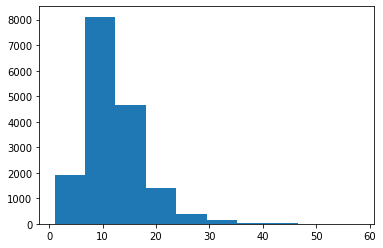

In [ ]:
plt.hist([len(i) for i in base.items])

In [ ]:
#let's padd and then 

In [ ]:
#now we create the language learner. This step is the pre -training. to_fp16 to go faster.
#learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3,config = None, pretrained=True).to_fp16()
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3,config = AW_config, pretrained=False).to_fp16()

In [ ]:
#check that all layers are trainable. 
summary_trainable(learn)

Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Embedding(11600, 400, padding_idx=1)                                                  1                 1                    4,640,000                               
Embedding(11600, 400, padding_idx=1)                                                  1                 1                    4,640,000                               
Linear(in_features=800, out_features=4650, bias=True)                                 2                 2                    3,724,650                               
Linear(in_features=1550, out_features=4650, bias=True)                                2                 2                    7,212,150                               
Linear(in_features=1550, out_features=4650, bias=True)                                2                 2                    7,212,150                               
Line

In [ ]:
#train the LM model. can be done multiple times, etc. 
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.306438,2.179765,0.609560,04:54


In [ ]:
#save the LM model 
learn.save("enc1")

In [ ]:
#save only the encoder part of the LM model. This is what we will reuse in ther other networks. 
learn.save_encoder("encoder")

Our current problem:

* I want to use approximate nierest neighborhood to pre-cluster the data, and then pairwise comparaison.
* But Because the data is comming from different sources, it has clusters corresponding to each data source.
* Thus we need to clean each source to homogenize the data.

To explore:
Maybe we don't need to clean evrything. If we generate vectors for each of items, we could try to substract the mean vector source (operating a data normalisation on the encodings). 

One small difficultie here is that raw tockenized/Numericalized data have different lenght. However, we could run it into the language model RNN and get the vector for each one!


# Getting the embeddings

Note: if you have an error, try running the first cell of trying out sentencepiece

To get the embeddings (using the fastai method), we feed each text by bits of lenght (bptt), and record the activations.
The we take the last activate, the max pooling and the average pooling. 

I use slightly modified fastai function because they make sure the data in on the gpu, etc.

In [ ]:
#a utility function inspired by fast.ai pad_collate
#https://github.com/fastai/fastai/blob/27ab982e94a75cd81920b5ab6155f6961d69174c/fastai/text/data.py#L128
#does packs together the list of numerical tockens, and add padding. 
def get_the_tensors(base):
  tocks = base.process().items
  padd = torch.zeros((len(tocks), 300)).long() + 1
  for i, tl in enumerate(tocks):
    padd[i,-len(tl):] = LongTensor(tl)
  return padd

In [ ]:
#copy the Sentencepiece data from drive to somewhere whitout spaces
#we want to use the same instance of sentencepeice as the one used for the LM model.
from shutil import copyfile
sp_temp=Path('test')
sp_temp.mkdir(exist_ok=True)
copyfile(work/'1spm.model', Path(sp_temp)/'spm.model')
copyfile(work/'1spm.vocab', Path(sp_temp)/'spm.vocab')
vocab = pickle.load(open(work/'vocab.pkl', 'rb'))

In [ ]:
base = pickle.load(open(work/"base.pkl", "rb"))

In [ ]:
#build the packed tensors from the tokenized data.
data = get_the_tensors(base)

To get the embeddings, we pass the data by bits of size pbtt through the encoder multiple times (since it is an RNN). The state of the RNN is recorder for the N last times. Then it is concate-pooled. 
This is done by two class below (straight taken from fastai.

In [ ]:
from fastai.text.data import *
from fastai.text.learner import *

#I took the pooling + linear layer from fastai and only kept the pooling part.
# I also only forward the x, not raw_outputs and outputs, which are used during the RNN training but not here.
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/learner.py#L232
class Pooling(Module):
    "Create a linear classifier with pooling."
    def __init__(self):
        super().__init__()

    def forward(self, input:Tuple[Tensor,Tensor, Tensor])->Tuple[Tensor,Tensor,Tensor]:
        from fastai.text.learner import masked_concat_pool
        raw_outputs,outputs,mask = input
        x = masked_concat_pool(outputs, mask)
        return x#, raw_outputs, outputs

#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/learner.py#L248
#No modification
class MultiBatchEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    def __init__(self, bptt:int, max_len:int, module:nn.Module, pad_idx:int=1):
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx

    def concat(self, arrs:Sequence[Sequence[Tensor]])->List[Tensor]:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[List[Tensor],List[Tensor],Tensor]:
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]
        for i in range(0, sl, self.bptt):
            r, o = self.module(input[:,i: min(i+self.bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
        return self.concat(raw_outputs),self.concat(outputs),torch.cat(masks,dim=1)

In [ ]:
AW_clasconfig = awd_lstm_clas_config.copy()

In [ ]:
AW_clasconfig["qrnn"]=True
AW_clasconfig["n_hid"]=1550
AW_clasconfig["n_layers"]=4
AW_clasconfig.pop("output_p")

0.4

In [ ]:
vocab_sz = len(data_lm.vocab.itos)
encoder = AWD_LSTM(vocab_sz=vocab_sz,**AW_clasconfig )

#HERE IS THE IMPORTANT PART:
#LOAD THE WHEIGHTS FROM THE PREVIOUSLY TRAINED ENCODER!
encoder.load_state_dict(torch.load(work/'models'/'encoder.pth', map_location=torch.device("cuda")))

<All keys matched successfully>

In [ ]:
#put the model in eval mode, because we don't want to update wheights and dropout while doing inference.
encoder.eval()

AWD_LSTM(
  (encoder): Embedding(11600, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(11600, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): QRNN(
      (layers): ModuleList(
        (0): QRNNLayer(
          (linear): WeightDropout(
            (module): Linear(in_features=800, out_features=4650, bias=True)
          )
        )
      )
    )
    (1): QRNN(
      (layers): ModuleList(
        (0): QRNNLayer(
          (linear): WeightDropout(
            (module): Linear(in_features=1550, out_features=4650, bias=True)
          )
        )
      )
    )
    (2): QRNN(
      (layers): ModuleList(
        (0): QRNNLayer(
          (linear): WeightDropout(
            (module): Linear(in_features=1550, out_features=4650, bias=True)
          )
        )
      )
    )
    (3): QRNN(
      (layers): ModuleList(
        (0): QRNNLayer(
          (linear): WeightDropout(
            (module): Linear(in_features=1550, out_features=1200, bias=True)
         

In [ ]:
#taken from fastai. No modification.
class SequentialRNN(nn.Sequential):
    "A sequential module that passes the reset call to its children."
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

In [ ]:
bptt = 10
max_len = 10 * bptt
benc = MultiBatchEncoder(20,200,encoder)
enc_model = SequentialRNN(benc, Pooling())
enc_model.eval()

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(11600, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(11600, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): QRNN(
          (layers): ModuleList(
            (0): QRNNLayer(
              (linear): WeightDropout(
                (module): Linear(in_features=800, out_features=4650, bias=True)
              )
            )
          )
        )
        (1): QRNN(
          (layers): ModuleList(
            (0): QRNNLayer(
              (linear): WeightDropout(
                (module): Linear(in_features=1550, out_features=4650, bias=True)
              )
            )
          )
        )
        (2): QRNN(
          (layers): ModuleList(
            (0): QRNNLayer(
              (linear): WeightDropout(
                (module): Linear(in_features=1550, out_features=4650, bias=True)
              )
            )
          )
        )
     

In [ ]:
#put it on GPU
enc_model = enc_model.cuda()

In [ ]:
#run the embeddings on GPU with the batch size bs. 
bs = 64
embeddings = []
with torch.no_grad():
  for i in range(0,len(data),bs):
    if len(data)%(i+1)==10: print(f"{i/len(data):.0%}")
    batch = data[i:min(i+bs, len(data))].cuda()
    out=enc_model(batch)
    embeddings.append(out.cpu().numpy())

In [ ]:
embeddings = np.vstack(embeddings)

In [ ]:
pickle.dump(embeddings, open(work/"embeddings.pkl", "wb"))

# using LSH or equivalent for fast clustering
[annoy](https://github.com/spotify/annoy)

[faiss](https://github.com/facebookresearch/faiss)

Currently using annoy. 
The current embeddings should be of length 1200,  as they are 
the last, mean and max activation of the RNN with an hidden size of 400

In [ ]:
pip install annoy

     |████████████████████████████████| 645kB 3.2MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297330 sha256=45df009d5f2eebd4fa10469d23278129e91b04e324c9fd0737080c54a2383a26
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [ ]:
embeddings = pickle.load(open(work/'embeddings.pkl', 'rb'))

In [ ]:
from annoy import AnnoyIndex

In [ ]:
#build an index for 400 long embeddings. 
f=400
t = AnnoyIndex(f, 'angular')

In [ ]:
#add every embeddings to it
for i in range(len(embeddings)):
  t.add_item(i, embeddings[i,:400])

In [ ]:
#build the tree
t.build(100)

True

In [ ]:
t.save(str(work/'100.ann'))

True

In [ ]:
t = AnnoyIndex(f, 'angular')
t.load(str(work/'100.ann'))

True

checking if the results make sens:

In [ ]:
strings = pickle.load(open(work/'strings.pkl', 'rb'))

In [ ]:
#get the 20 closest items to the 0th. 
close = t.get_nns_by_item(0, 20,)

In [ ]:
#and their visualization.
[strings[c] for c in close]

['xxfld 364 acer v173 djobd 75hz .0"  (um.bv3aa.d02) -  xxfld 498 5:4 xxfld 416 250 cd/m² xxfld 60 no xxfld 646 acm 20000:1 (1000:1) xxfld 1140 16700000 xxfld 517 acer xxfld 434 v173 djobd xxfld 476 um.bv3aa.d02 xxfld 1390 1280 x 1024 xxfld 139 75hz xxfld 532 5 ms xxfld 1659 17" xxfld 1053 no',
 'xxfld 364 acer um.bv6aa.003 75hz .0"  (um.bv6aa.003) -  xxfld 498 5:4 xxfld 416 250 cd/m² xxfld 60 no xxfld 646 100,000,000:1 xxfld 1140 16700000 xxfld 517 acer xxfld 476 um.bv6aa.003 xxfld 1390 1280 x 1024 xxfld 139 75hz xxfld 532 5 ms xxfld 1659 17" xxfld 1053 no',
 'xxfld 364 acer um.bv6aa.002 75hz .0"  (um.bv6aa.002) -  xxfld 498 5:4 xxfld 416 250 cd/m² xxfld 60 no xxfld 646 100,000,000:1 xxfld 1140 16700000 xxfld 517 acer xxfld 476 um.bv6aa.002 xxfld 1390 1280 x 1024 xxfld 139 75hz xxfld 532 5 ms xxfld 1659 17" xxfld 1053 no',
 'xxfld 364  as172-bk 76hz .0"  (as172-bk) -  xxfld 498 5:4 xxfld 416 250 cd/m² xxfld 60 no xxfld 646 1000:1 xxfld 517 nec xxfld 476 as172-bk xxfld 1390 1280 x 1024

Please not how all of the "closest" are actually from the same source!

It is not that bad! We see that we mainly have acer of type 
umbvXaa or planar something. 

Ithing that one problem is that close tuple will automatically be the one that come form the same source... I see two solutions for that:
* Query for the closest tuple in each source separately
* Make some magic normalisation to "remove" source locality.

### removing source locality

I'm going to try and remove information from source by, 
for each source, removing the mean and dividing by the variance

In [ ]:
source_len = [len(source) for source in jdic]
start  = np.cumsum([0]+source_len)

In [ ]:
indexes = list(zip(start[:-1], start[1:]))

In [ ]:
#Z-score normalisation for each object. 
norm_embs = []
for (i,j) in indexes:
  source_emb = embeddings[i:j,:]
  mean = source_emb.mean(axis=0)
  std = source_emb.std(axis=0)
  norm_embs.append((source_emb-mean)/std)
norm_embs = np.vstack(norm_embs)

In [ ]:
#doing the query again
f=400
t = AnnoyIndex(f, 'angular')
for i in range(len(embeddings)):
  t.add_item(i, norm_embs[i,:400])
t.build(100)
t.save(str(work/'100.ann'))
t = AnnoyIndex(f, 'angular')
t.load(str(work/'100.ann'))

IndexError: ignored

In [ ]:
close = t.get_nns_by_item(0, 20,)

In [ ]:
[strings[c] for c in close]

[]

It does not seems to change anything much!
I still think that "source locality" can be a really big bother. I think this is where data augmentation and playing with random walks will help smoothing this out. 

Maybe one could even imagine a deep learning approach with adversarial networks to remove source specific information!

As for now, we will be on our trump card: fine tuning the embeddings!

Indeed, if we fine tune the embedding by learning from the label dataset, the RNN should then focus on the part of the text that are important for 'OUR' classification!

### removing source by searching in each dataset

In [ ]:
source_len = pickle.load(open(work/'source_len.pkl', 'rb'))
start  = np.cumsum([0]+source_len)

In [ ]:
indexes = list(zip(start[:-1], start[1:]))

In [ ]:
f=1200
close=[]
distances=[]
for u, (i,j) in enumerate(indexes):
  print(f"{u/len(indexes):.0%}")
  t = AnnoyIndex(f, 'angular')
  t.build(50)
  t.add_item(0, embeddings[0])
  for k,e in enumerate(embeddings[i:j]): t.add_item(k, e)
  c,d = t.get_nns_by_item(0, 5,include_distances=True)
  print(c)
  close+=[i+k for k in c[1:]]
  distances+=d[1:]

0%
[0, 6, 4, 35, 45]
4%
[0, 3, 24, 29, 14]
8%
[0, 48, 9, 3, 36]
12%
[0, 47, 26, 46, 21]
15%
[0, 25, 31, 8, 26]
19%
[0, 26, 21, 2, 48]
23%
[0, 3, 44, 11, 22]
27%
[0, 11, 39, 44, 8]
31%
[0, 10, 48, 49, 8]
35%
[0, 10, 25, 36, 12]
38%
[0, 35, 15, 11, 31]
42%
[0, 33, 46, 38, 2]
46%
[0, 42, 1, 29, 26]
50%
[0, 2, 31, 7, 48]
54%
[0, 7, 37, 31, 42]
58%
[0, 12, 4, 20, 5]
62%
[0, 7, 48, 30, 26]
65%
[0, 45, 44, 49, 7]
69%
[0, 4, 35, 22, 38]
73%
[0, 21, 38, 33, 32]
77%
[0, 13, 27, 37, 28]
81%
[0, 7, 27, 46, 38]
85%
[0, 30, 16, 22, 33]
88%
[0, 18, 44, 1, 36]
92%
[0, 2, 27, 41, 30]
96%
[0, 46, 27, 45, 28]


In [ ]:
list(sorted([(strings[i],d) for i,d in zip(close,distances)],key=lambda x:x[1]))

[('xxfld 364  - 240b4lpycs/00 |  240b4lpycs/00 (24 )  with  backlight 1920x1200 (silver) xxfld 498 16:10 xxfld 878 1 x 3.5mm pc audio input xxfld 1371 led xxfld 416 250cd/m2 xxfld 881 silver xxfld 646 1,000:1 (static) , 20,000,000:1 (dynamic) xxfld 747 smartimage is an exclusive leading edge philips technology that analyses the content displayed on yo xxfld 1168 1 x dvi-d xxfld 814 55.5cm (w) x 22.7cm (d) x 54.3cm (h) - weight 5.83kg xxfld 161 operating temperature 0 to 40°c - humidity 20 to 80% xxfld 831 yes xxfld 1261 0.270 x 0.270mm xxfld 690 20w (max) / 0.2w (standby) xxfld 1183 monitor xxfld 1406 1920 x 1200 pixels xxfld 532 5ms xxfld 717 30khz to 83khz xxfld 112 56hz to 76hz xxfld 1258 24in (diagonal) xxfld 774 tft lcd 16.7 million colour xxfld 117 2 x 1.5w xxfld 1174 ±65° xxfld 862 separate sync, sync on green xxfld 1466 -5 to +20° xxfld 1498 1 x 15-pin d-sub xxfld 1010 170° (horizontal - max) x 160° (vertical - max) xxfld 1308 100 to 240vac / 50 to 60hz xxfld 1276 yes , vesa co

In [ ]:
t.save(str(work/'100.ann'))

True

In [ ]:
t = AnnoyIndex(f, 'angular')
t.load(str(work/'100.ann'))

True

Getting the closest points from each source did not seemed to work great. 

We need better embeddings and this is why we use the labelled dataset to fine tune the encoder.

---
# Getting the siamese data
---

We build a representation of the labelled dataset (itemA, itemB, match)
that works with fastai api.

In [ ]:
#base class to represent two texts.
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/data.py#L278
#modified to hold a tuple of texts.
class SiameseText(ItemBase):
    def __init__(self, l:Text, r:Text): 
      self.l, self.r = l,r

    @property
    def data(self):
      return [self.l.data,self.r.data]

    def apply_tfms(self, tfms, **kwargs):
      self.l = self.l.apply_tfms(tfms, **kwargs)
      self.r = self.r.apply_tfms(tfms, **kwargs)
      return self

    def __str__(self):  return f"{str(self.l)}\n{str(self.r)}"

object1 
(object1 xxNEWOBJCT object2) 1/2 
(obect2 xxNEWOBJT object1) 

In [ ]:
#function to gather sample into a batch
#adapted from pad_collate in fastai
#but for 2 inputs now. 
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/data.py#L128
def duo_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding for a tuple. Flips token order if needed"
    samples = to_data(samples)
    def pad(j, pad_first=pad_first, pad_idx=pad_idx, backwards=backwards):
      max_len = max(len(s[0][j]) for s in samples)
      res = torch.zeros(len(samples), max_len).long() + pad_idx
      if backwards: pad_first = not pad_first
      for i,s in enumerate(samples):
          if pad_first: res[i,-len(s[0][j]):] = LongTensor(s[0][j])
          else:         res[i,:len(s[0][j]):] = LongTensor(s[0][j])
      if backwards: res = res.flip(1)
      return res
    
    return (pad(0),pad(1)), tensor(np.array([s[1] for s in samples]))

In [ ]:
#get together the datasets (train and validation) into a dataloader using the special duo_pad_collate function.
#and a weighted sampler for the train set.
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/data.py#L146
class DuoDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    "with a weihted random sampler and a collate function for the duo."
    collate_fn=duo_pad_collate #USING THE CUSTOM COLLATE FUNCTION 
    train_sampler=torch.utils.data.WeightedRandomSampler #USING A WHEIGHTED SAMPLER
    
    @classmethod
    def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
               val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
               device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, **dl_kwargs)->'DataBunch':
        "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)

        #get the weights for wheited sampling. This assume we gave a dataframe with a weight column to the itemList.
        weights = datasets[0].inner_df.weight.to_numpy()
        num_samples=int(1e4)
        #wheighted sampler for the trainning set.
        train_sampler = cls.train_sampler(weights=weights,num_samples=num_samples,replacement=True)        
        
        dls = [DataLoader(datasets[0], batch_size=bs ,shuffle=False,drop_last=True,sampler=train_sampler, num_workers=num_workers, **dl_kwargs)]
        
        #simple iterative sampler for the others. (as is done in fastai api)
        dls += [DataLoader(d, b, shuffle=False, drop_last=False, num_workers=num_workers, **dl_kwargs) for d,b in
               zip(datasets[1:], (val_bs,val_bs,val_bs)) if d is not None]

        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=cls.collate_fn, no_check=no_check)

NameError: ignored

In [ ]:
#list that get you the two item. Their position left/right is random
#NOTA: Might not be necessary to differential between left and right if the distance layer used is symetric.
#NOTA: to be used using the from_df factory method. 
#Inspired by the textList
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/data.py#L317

class DuoList(ItemList):
  _bunch=DuoDataBunch
  import random
  def __init__(self, items:Iterator, source:TextList, indexer:Series, vocab=None, **kwargs):
    super().__init__(items, **kwargs)
    self.source, self.indexer,self.vocab = source, indexer,vocab
    self.copy_new+=["source", "indexer","vocab"]

  def get(self, i): #this is the function called to get  pair each time. 
    l,r = super().get(i) #super.get will get the i-th item from self.items, which is a tuple of indexes for two items
    sl,sr = self.source.get(l), self.source.get(r) #get the corresponding dictionnaries from the two indexes
    return  SiameseText(sl,sr) if random.choice([True, False]) else SiameseText(sr,sl) #wrap them into SiameseText, and randomly permute.
  
  @classmethod
  def from_df(cls, df, source, indexer, cols=[0,1]):
    #df contains itemA ids, itemB items, wheights, train & validation split. 
    #source is the list of items we built for the LM
    #indexer is the list giving the mapping from index to sourcename//number (ebay//34)
    #nota: inner_df is part of fsatai API and is passed as a kwargs to the parent class constructor.
    #it will be save as a member variable.
    items = zip(df.iloc[:,cols[0]].map(indexer), df.iloc[:,1].map(indexer))
    return cls(items=items, source=source, indexer=indexer, vocab=source.vocab, inner_df=df,)
  

In [ ]:
#class to perform so initial pre-processing on the label dataset.
#just calculate weights for the wheited random sampler to do its job
class LabelSplitter():
  def __init__(self, maxlen:int=int(1e4),valp:float=0.05, label="label"):
    self.maxlen,self.valp,self.label=maxlen,valp,label

  def _traintestsplit(this, df:DataFrame):
    #put a column "is_valid" with valp% of validation data
    dfv = df.sample(frac=this.valp)
    df["is_valid"] = df.index.isin(dfv.index)
    return df[~df.is_valid], df[df.is_valid]
  
  def _weight(this, df, resample = True):
    #rebalance the 1 class to the same number.
    ipp=len(df)/sum(df[this.label]==1)
    df.loc[df.label==1, "weight"]= ipp if resample else 1
    df.loc[df.label==0, "weight"]=1
    return df
  def transform(self, df):
    dft,dfv = self._traintestsplit(df)
    dft = self._weight(dft.copy())
    return pd.concat([dft,dfv])

---
Try to load the data in

---

In [ ]:
#mark the validation set and add weights
labelsp=LabelSplitter().transform(label)

In [ ]:
#left is used to get the corresponding item
#right same
#label is used to give the label (0/1 if it is a match)
#weight is used to upsample by the weight the minory class 1.
labelsp.head()

,left_spec_id,right_spec_id,label,is_valid,weight
0,www.ebay.com//12307,www.ebay.com//23720,1,False,105.387226
1,catalog.com//254,www.ebay.com//19927,1,False,105.387226
2,catalog.com//254,www.ebay.com//22113,1,False,105.387226
3,www.ebay.com//19927,www.ebay.com//22113,1,False,105.387226
4,www.ebay.com//23720,www.officedepot.com//289,1,False,105.387226


In [ ]:
#some reformating to build the index -> name//number mapping
id_label = pd.Series(range(len(id)), index=[l[19:-5].replace("/", "//") for l in id])

In [ ]:
id_label.head()

ca.pcpartpicker.com//475    0
ca.pcpartpicker.com//262    1
ca.pcpartpicker.com//258    2
ca.pcpartpicker.com//239    3
ca.pcpartpicker.com//286    4
dtype: int64

In [ ]:
#copy the Sentencepiece data from drive to somewhere whitout spaces
#because we want to use the same sentencepiece data as the one used for LM
from shutil import copyfile
sp_temp=Path('tempemb')
sp_temp.mkdir(exist_ok=True)
copyfile(work/'1spm.model', Path(sp_temp)/'spm.model')
copyfile(work/'1spm.vocab', Path(sp_temp)/'spm.vocab')
vocab = pickle.load(open(work/'vocab.pkl', 'rb'))

In [ ]:
#loads directly the tockenized/numericalized data used for lm.
base = pickle.load(open(work/"base.pkl", "rb"))

In [ ]:
#create the duo list. 
#indexing into duo will get the index in labelsp
#and then get the two corresponding tokens list from base.
duo = DuoList.from_df(labelsp, source=base, indexer=id_label)

In [ ]:
#split where df is is_valid,
#label( 0/1) using the "label" column
data = duo.split_from_df(col="is_valid").label_from_df(cols="label").databunch()

You can deactivate this warning by passing `no_check=True`.


In [ ]:
#check that padding is done correctly, and that upsampling is also done.
data.one_batch()

([tensor([[    1,     1,     1,  ...,     4,   156,  2321],
          [    1,     1,     1,  ...,    54,  1713,  7849],
          [    1,     1,     1,  ..., 11525, 11529, 11524],
          ...,
          [    1,     1,     1,  ...,   378,  6854,    90],
          [    1,     1,     1,  ...,   276,   219,   545],
          [    1,     1,     1,  ...,     4,   265,  5882]]),
  tensor([[    1,     1,     1,  ...,     4,   156,  2321],
          [    1,     1,     1,  ...,     4,   156,   794],
          [    1,     1,     1,  ...,   190,   295, 11536],
          ...,
          [    2,     4,    77,  ...,   178,    42,   147],
          [    1,     1,     1,  ...,   190,   295, 11536],
          [    1,     1,     1,  ...,     4,   587,   302]])],
 tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]))

See that data-reblancing is done by the sampler. 

In [ ]:
data.save(work/"datac.pkl")

---
# Define the network

---

In [ ]:
# this moduls takes the two enbeddings and concats their value, and their scalar by scalar distance.
class SimpleERDistance(Module):
  #goal is to combine the two encoding tensors
  def __init__(self):
    super().__init__()

  def forward(self, input:Tuple[Tensor, Tensor]) ->Tensor:
    #get the two encodings as a 2D Tensor
    l,r=input
    diff = l-r
    l1 = torch.abs(l-r)
    l2 = torch.square(l-r)
    return torch.cat([l1,l2,l,r], dim=1)

In [ ]:
#again taken from fastai and modified a bit to work with my context. 
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/learner.py#L232
#it just skip the pooling part.
class ERHead(Module):
    "Create a linear classifier with pooling."
    def __init__(self, layers:Collection[int], drops:Collection[float]):
        mod_layers = []
        if len(drops) != len(layers)-1: raise ValueError("Number of layers and dropout values do not match.")
        activs = [nn.ReLU(inplace=True)] * (len(layers) - 2) + [None]
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activs):
            mod_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*mod_layers)
    def forward(self, input:Tensor)->Tensor:
        x = self.layers(input)
        return x

In [ ]:
#the main module that combines the encoder to get the embeddings, 
#the distance to get a single vector from the two embeddings
#and the head to output a vector with 2 values for the 2 classes 0 and 1.
class er_net(Module):
  def __init__(self, encoder, distance, head):
    self.encoder, self.distance, self.head = encoder, distance ,head
    self.items = [encoder,distance,head]

  def reset(self):
    for c in self.children():
        if hasattr(c, 'reset'): c.reset()

  def __getitem__(self,index):
    return self.items[index]
  
  def forward(self, input_left, input_right):
    from fastai.text.learner import masked_concat_pool
    #get the encodings thoses are [embeding size*3, maxlen/bptt ], by default [400*3, 20]
    input = [input_left, input_right]
    rawl,outl,maskl = self.encoder(input[0]) 
    #nota; the encoder gives the raw value, output value, and mask value 
    #see the corresponding fastai class.
    rawr,outr,maskr = self.encoder(input[1])
    #pool the last values of the encodings.
    left, right = masked_concat_pool(outl, maskl), masked_concat_pool(outr, maskr)
    #[embding size*3] once pooled
    #conbine the two.
    x = self.distance((left, right))
    o = self.head(x)
    return o, rawl, outl, rawr, outr

In [ ]:
#get the correct layer groups for our model. This is used
#to do discriminative learning (see fastai doc).
#https://github.com/fastai/fastai/blob/75653d571060d2af03e145e5c623bb854811a223/fastai/text/models/awd_lstm.py#L168
#model[0] is the encoder, model[1] is the distance layer (not wheights to learn is this layer) model[2] is the head
def duo_awd_lstm_clas_split(model:nn.Module) -> List[List[nn.Module]]:
    "Split a RNN `model` in groups for differential learning rates."
    groups = [[model[0].module.encoder, model[0].module.encoder_dp]]
    groups += [[rnn, dp] for rnn, dp in zip(model[0].module.rnns, model[0].module.hidden_dps)]
    return groups + [[model[2]]]

In [ ]:
#a slight update on the RNNtrainer from fastai
#to work with the siamese data
#https://github.com/fastai/fastai/blob/781cbcfb08b1a6c22551f2559e55ca0aa555b93c/fastai/callbacks/rnn.py#L8
class DuoRNNTrainer(LearnerCallback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    def __init__(self, learn:Learner, alpha:float=0., beta:float=0.):
        super().__init__(learn)
        self.not_min += ['raw_out_l', 'out_l', 'raw_out_r', 'out_r']
        self.alpha,self.beta = alpha,beta
        
    def on_epoch_begin(self, **kwargs):
        "Reset the hidden state of the model."
        self.learn.model.reset()

    def on_loss_begin(self, last_output:Tuple[Tensor,Sequence[Tensor],Sequence[Tensor],Sequence[Tensor],Sequence[Tensor]], **kwargs):
        "Save the extra outputs for later and only returns the true output."
        #changed to save outputs for the two item we pass through
        self.raw_out_l,self.out_l = last_output[1],last_output[2]
        self.raw_out_r,self.out_r = last_output[3],last_output[4]
        return {'last_output': last_output[0]}

    def on_backward_begin(self, last_loss:Rank0Tensor, last_input:Tensor, **kwargs):
        "Apply AR and TAR to `last_loss`."
        #change to apply AR and TAR on both of the items
        for (raw_out, out) in zip((self.raw_out_l, self.out_l),(self.raw_out_r,self.out_r)):
          if self.alpha != 0.:  last_loss += self.alpha * out[-1].float().pow(2).mean()
          if self.beta != 0.:
              h = raw_out[-1]
              if len(h)>1: last_loss += self.beta * (h[:,1:] - h[:,:-1]).float().pow(2).mean()
          
        return {'last_loss': last_loss}

In [ ]:
#same, see fastai RNNTrainer
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/learner.py#L45
class DuoRNNLearner(Learner):
    "Basic class for a `Learner` in NLP."
    def __init__(self, data:DataBunch, model:nn.Module, split_func:OptSplitFunc=None, clip:float=None,
                 alpha:float=2., beta:float=1., metrics=None, **learn_kwargs):
        is_class = (hasattr(data.train_ds, 'y') and (isinstance(data.train_ds.y, CategoryList) or
                                                     isinstance(data.train_ds.y, LMLabelList)))
        metrics = ifnone(metrics, ([accuracy] if is_class else []))
        super().__init__(data, model, metrics=metrics, **learn_kwargs)
        #Changed here to use the custom DuoRNNTrainer
        self.callbacks.append(DuoRNNTrainer(self, alpha=alpha, beta=beta))
        if clip: self.callback_fns.append(partial(GradientClipping, clip=clip))
        if split_func: self.split(split_func)

    def save_encoder(self, name:str):
        "Save the encoder to `name` inside the model directory."
        if rank_distrib(): return # don't save if slave proc
        if is_pathlike(name): self._test_writeable_path()
        encoder = get_model(self.model)[0]
        if hasattr(encoder, 'module'): encoder = encoder.module
        torch.save(encoder.state_dict(), self.path/self.model_dir/f'{name}.pth')

    def load_encoder(self, name:str, device:torch.device=None):
        "Load the encoder `name` from the model directory."
        encoder = get_model(self.model)[0]
        if device is None: device = self.data.device
        if hasattr(encoder, 'module'): encoder = encoder.module
        distrib_barrier()
        encoder.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=device))
        self.freeze()
        return self

    def load_pretrained(self, wgts_fname:str, itos_fname:str, strict:bool=True):
        "Load a pretrained model and adapts it to the data vocabulary."
        old_itos = pickle.load(open(itos_fname, 'rb'))
        old_stoi = {v:k for k,v in enumerate(old_itos)}
        wgts = torch.load(wgts_fname, map_location=lambda storage, loc: storage)
        if 'model' in wgts: wgts = wgts['model']
        wgts = convert_weights(wgts, old_stoi, self.data.train_ds.vocab.itos)
        self.model.load_state_dict(wgts, strict=strict)
        return self

    def get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None, with_loss:bool=False, n_batch:Optional[int]=None,
                  pbar:Optional[PBar]=None, ordered:bool=True) -> List[Tensor]:
        "Return predictions and targets on the valid, train, or test set, depending on `ds_type`."
        self.model.reset()
        if ordered: np.random.seed(42)
        preds = super().get_preds(ds_type=ds_type, activ=activ, with_loss=with_loss, n_batch=n_batch, pbar=pbar)
        if ordered and hasattr(self.dl(ds_type), 'sampler'):
            np.random.seed(42)
            sampler = [i for i in self.dl(ds_type).sampler]
            reverse_sampler = np.argsort(sampler)
            preds = [p[reverse_sampler] for p in preds]
        return preds


In [ ]:
#function to get the model and put it into a learner using the right layer groups
#same as above see text_classifer_learner from fastai. udpated to use the duo functions.
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/learner.py#L289
def duo_text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=70*20, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    #Changed here to use the get_duo_text_classifier
    model = get_duo_text_classifier(arch, len(data.vocab.itos), data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    from fastai.text.learner import _model_meta, RNNLearner
    meta = _model_meta[arch]
    #Changed here to use the DuoRNNLearner
    learn = DuoRNNLearner(data, model, split_func=duo_awd_lstm_clas_split, **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
      
    return learn

In [ ]:
#function to create the model
#see fastai doc of get_text_classifier for it.
#https://github.com/fastai/fastai/blob/868513671bca40edf69729552be51d3503873d99/fastai/text/learner.py#L272
def get_duo_text_classifier(arch:Callable, vocab_sz:int, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a duo text classifier from `arch` and its `config`, maybe `pretrained`."
    from fastai.text.learner import _model_meta, MultiBatchEncoder
    meta = _model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    #Changed here From [config[meta['hid_name']] * 3] to  [config[meta['hid_name']] *3*4] because 
    #it used to be hid_size * 3 for the [last_activation, max_pooling, avg_pooling]
    #now it takes the output of the distance layer:
    #[left, right, squared difference, absolute difference] for each of those [last_activation, max_pooling, avg_pooling]
    layers = [config[meta['hid_name']] *3*4] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    #Changed herer:
    #build the encoder
    #the distance layer
    #and the liner layer
    encoder = MultiBatchEncoder(bptt, max_len, arch(vocab_sz, **config), pad_idx=pad_idx)
    distance = SimpleERDistance()
    head = ERHead(layers=layers, drops=ps)
    #and the model using thoses three
    model = er_net(encoder, distance, head)
    return model if init is None else model.apply(init)

# fine tunnning for ER

In [ ]:
#get the data we prepared before
data=load_data(work, "datac.pkl",bs=64)

You can deactivate this warning by passing `no_check=True`.


In [ ]:
AW_config =awd_lstm_clas_config.copy()

In [ ]:
AW_config

{'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.05,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'n_hid': 1152,
 'n_layers': 3,
 'output_p': 0.4,
 'pad_token': 1,
 'qrnn': False,
 'weight_p': 0.5}

In [ ]:
#us the qrnn setings we used for LM
AW_config["qrnn"]=True
AW_config["n_hid"]=1550
AW_config["n_layers"]=4

In [ ]:
#we are feeding the RNN by bits of size bptt (50). 
#we record activation only on the last max_len tockens of the vector.
bptt = 50
max_len = 300

In [ ]:
learn = duo_text_classifier_learner(data, arch=AWD_LSTM, bptt=bptt, max_len=max_len,config=AW_config, )
learn = learn.to_fp16()

In [ ]:
#very important, this is where we used the encoder we trained with LM
learn.load_encoder("encoder");

In [ ]:
learn.summary()

er_net
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [50, 400]            0          False     
______________________________________________________________________
RNNDropout           [50, 1550]           0          False     
______________________________________________________________________
RNNDropout           [50, 1550]           0          False     
______________________________________________________________________
RNNDropout           [50, 1550]           0          False     
______________________________________________________________________
SimpleERDistance     [4800]               0          False     
______________________________________________________________________
BatchNorm1d          [4800]               9,600      True      
______________________________________________________________________
Dropout              [4800]               0          False     
_______________________________________________________

In [ ]:
summary_trainable(learn)

Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Embedding(11600, 400, padding_idx=1)                                                  1                 0                    0                                       
Embedding(11600, 400, padding_idx=1)                                                  1                 0                    0                                       
Linear(in_features=800, out_features=4650, bias=True)                                 2                 0                    0                                       
Linear(in_features=1550, out_features=4650, bias=True)                                2                 0                    0                                       
Linear(in_features=1550, out_features=4650, bias=True)                                2                 0                    0                                       
Line

In [ ]:
#let start by fitting the linear head.
#freeze will lock in place the wheights of the encoder 
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


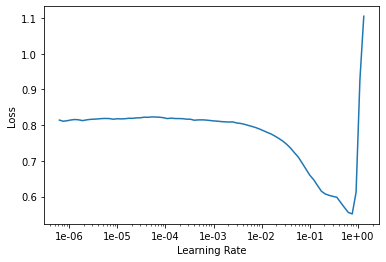

In [ ]:
#using fastai elbow method to find a good learning rate
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 1e-1)
learn.save("class1")

epoch,train_loss,valid_loss,accuracy,time
0,0.090538,0.054174,0.990644,03:26
1,0.058300,0.047316,0.990644,03:26
2,0.051335,0.047537,0.990644,03:26


In [ ]:
learn.load("class1")

DuoRNNLearner(data=DuoDataBunch;

Train: LabelList (105598 items)
x: DuoList
▁xxbos ▁xxfld ▁1103 ▁elo ▁1515 l ▁15" ▁touchscreen ▁4 ▁3 ▁14 ▁20 ▁igr ml j 9 313 ▁| ▁xxfld ▁1485 ▁4:3 ▁xxfld ▁34 ▁elo ▁xxfld ▁1458 ▁250 ▁nit ▁xxfld ▁310 ▁16.7 ▁million ▁colors ▁xxfld ▁1402 ▁new : ▁a ▁brand - new , ▁unused , ▁unopened , ▁undamaged ▁item ▁in ▁its ▁original ▁packaging ▁( where ▁packaging ▁is ▁app ▁xxfld ▁175 ▁500:1 ▁xxfld ▁28 ▁7411493 278 488 ▁xxfld ▁1465 ▁china ▁rohs , ▁mpr ▁ii ▁xxfld ▁755 ▁3 ▁year ▁xxfld ▁442 ▁1024 ▁x ▁768 ▁xxfld ▁854 ▁14 .20 ▁ms ▁xxfld ▁848 ▁15" ▁xxfld ▁1105 ▁capacitive
▁xxbos ▁xxfld ▁1103 ▁elo ▁1000 ▁series ▁1515 l ▁touch ▁screen ▁igrm v 213 94 ▁| ▁xxfld ▁858 ▁e 61 1558 ▁xxfld ▁1485 ▁4:3 ▁xxfld ▁1262 ▁elo ▁xxfld ▁1458 ▁250 ▁cd ▁/ ▁mâ 2 ▁xxfld ▁365 ▁16.2 m ▁colors , ▁24- bit ▁(16.7 m ▁colors ) ▁xxfld ▁310 ▁16.2 ▁million ▁colors ▁xxfld ▁1402 ▁new : ▁a ▁brand - new , ▁unused , ▁unopened , ▁undamaged ▁item ▁in ▁its ▁original ▁packaging ▁( where ▁packaging ▁is ▁app ▁xxfld ▁175 ▁50

In [ ]:
#unfreeze to make the encoder wheights updatable too
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.061912,0.048319,0.990644,07:30
1,0.051838,0.045834,0.990644,07:31
2,0.054422,0.045877,0.990644,07:33


In [ ]:
learn.save("class3")

In [ ]:
#get preds will returns the output and real value for the validation set. 
out = learn.get_preds()

KeyboardInterrupt: ignored

In [ ]:
out

[tensor([[0.9731, 0.0269],
         [0.9731, 0.0269],
         [0.8950, 0.1050],
         ...,
         [0.9761, 0.0239],
         [0.9757, 0.0243],
         [0.9934, 0.0066]]), tensor([1, 1, 1,  ..., 0, 0, 0])]

In [ ]:
import pickle

In [ ]:
pickle.dump(out, open(work/"out.pkl", 'wb'))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


# checking the score

In [ ]:
#load the output from the validatiooutn set
out = pickle.load(open(work/"out.pkl",'rb'))

In [ ]:
from sklearn.metrics import roc_curve,plot_roc_curve,auc, f1_score

In [ ]:
#get the true label
#and the score for the class 1. 
y_true = out[1]
scores = out[0][:,1]

In [ ]:
#get some info on false/true postive rate.
fpr, tpr, thresholds = roc_curve(y_true, scores,)

In [ ]:
import matplotlib.pyplot as plt

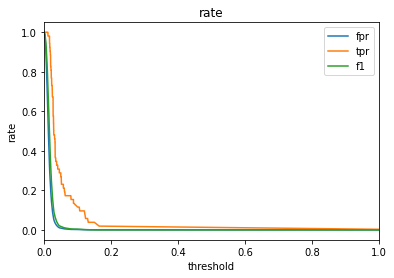

In [ ]:
#plt.plot(fpr, tpr)
eps=1e-9
f1 = 2*(fpr*tpr)/(fpr+tpr+eps)
plt.plot(thresholds,fpr, label="fpr")
plt.plot(thresholds, tpr, label="tpr")
plt.plot(thresholds, f1, label="f1")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("rate")
plt.title("rate")
plt.xlim((0,1))
plt.show()

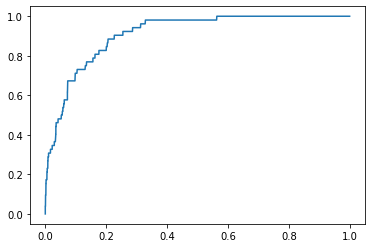

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
#get the auc score.
u = auc(fpr, tpr)

In [ ]:
u

0.9106586520998071

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
(scores>0.2).numpy().astype(int)

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [ ]:
f1 = [f1_score(y_true,(scores>t).numpy().astype(int) ) for t in np.linspace(0,1,200)]

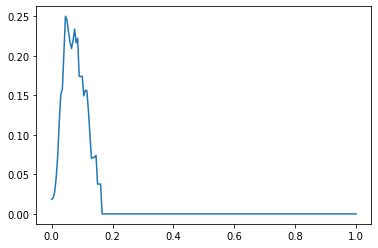

In [ ]:
#plot the F1 score on the validation set, depending on the threshold we use for the score. 
#since the class are heavily imbalanced, it seemed natural to choose a threshold that is not at 0.5
#but at 0.99 since we have  a 1 for 100 imbalance.
plt.plot(np.linspace(0,1,200), f1)